In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CIFAR10 datasets를 통해서 해당 데이터를 분류하는 모델을 만든다.

In [2]:
%config Completer.use_jedi = False

In [3]:
# cifar10 dataset을 통해 classification model을 만든다.

from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)

2024-02-11 08:29:08.116324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 08:29:08.116451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 08:29:08.286115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)


In [4]:
# 첫번째 이미지에 대한 정보 확인

print(train_images[0,:,:])
print(train_labels[0,:])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


In [5]:
# train_labels 10개 출력
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
# print(train_labels[:10])

for i in range(10):
    print(train_labels[i])
    print(NAMES[train_labels[i,0]])

[6]
frog
[9]
truck
[9]
truck
[4]
deer
[1]
automobile
[1]
automobile
[2]
bird
[7]
horse
[8]
ship
[3]
cat


### CIFAR10 데이터 시각화
* 이미지 크기는 32*32이며, RGB채널, 수식으로 표현하면 32*32*3
* 이미지를 보면 전반적으로 label에 해당하는 대상이 가운데에 있고, 그 이미지에서 label 대상의 비중이 크다

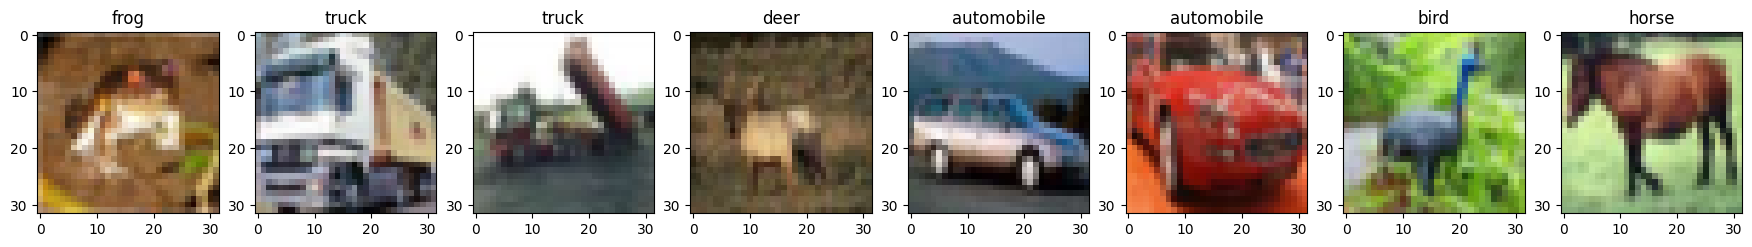

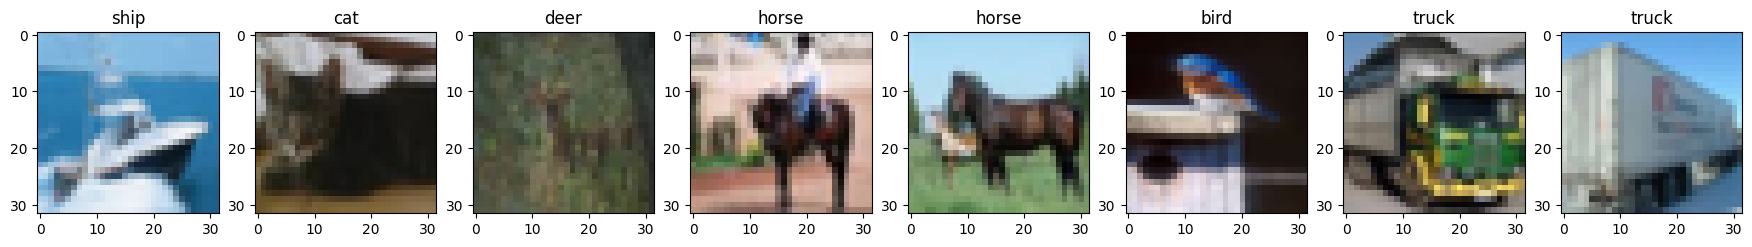

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()  # 원래 labels가 2차원 데이터로 들어오는데 이걸 1차원으로 축소
        axs[i].set_title(NAMES[int(label)])

show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### data preprocessing
* iamge array의 0 ~ 255 사이의 값으로 되어 있는 pixel intensity 값을 0 ~ 1 사이 값으로 변환. 각 pixel을 255.0으로 나눈다.
* label array는 숫자형 값으로 바꾸고 이후 one hot encoding을 적용할지 선택한다. 이번 모델은 one hot encoding을 적용하지 않는다.
* image array, label array 모두 np.float32로 형변환. np.float32는 tensor 변환시 tf.float32로 변환되어 기본적으로 tensorflow backend keras는 tf.float32를 기반으로 한다.

In [7]:
# label은 one hot encoding이 keras에서 활용이 용이하나 이번에는 sparse categorical crossentropy를 사용해보기 위해 적용하지 않는다.

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0 ~ 1 사잇값으로 scale 및 float32로 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

train_images, train_labels = get_preprocessed_data(train_images, train_labels)
test_images, test_labels = get_preprocessed_data(test_images, test_labels)

In [8]:
# 전처리 적용 여부 확인
train_images[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [9]:
# keras는 CNN 2D 모델에 학습 데잍터 입력 시 반드시 image array는 4차원 배열이 되어야 한다.
# rgb 채널 이미지 array는 기본적으로 3차원인데 여기서 이미지의 개수를 포함해서 4차원이 형성되는 구조다.
# 만일 grayscale이 2차원 이미지 array라고 해도 의도적으로 채널을 명시해서 3차원으로 만들어 이미지 개수를 포함하면 4차원이 되도록 해야한다.

print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# labels 데이터가 2차원임. 이를 keras 모델에 입력해도 문제없이 작동한다.
# 그치만 one hot encoding의 적용 여부를 명확하게 알 수 있게 1차원으로 만들어주자

train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

print(train_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


### Model 생성
* CNN Model의 첫 layer에는 input_layer을 넣고 shape는 이미지 사이즈에 맞게 설정
* conv 연산을 적용하고 maxpooling을 적용. maxpooling 적용 후에는 필터 개수를 증가시킴
* maxpooling 이후 feature map 사이즈는 작아지지만 채널(깊이)은 늘어나는 형태.
* CIFAR10의 Label수가 10개이므로 Classification을 위한 맨 마지막 Dense layer의 units 갯수는 10개임
* label값이 원-핫 인코딩 되지 않았기 때문에 model.compile()에서 loss는 반드시 sparse_categorical_crossentropy여야함.

In [11]:
IMAGE_SIZE = 32

In [12]:
# 이미지 자체 사이즈가 3*3으로 크지 않아서 kernel_size를 지나치게 크게 잡을 필요가 없다.
# 초기 receptive_field 크기 설정에 대해서 정해진 법칙은 없고 돌려보면서 확인해야 한다.

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)  # 이런식으로 conv2d와 activation을 별개로 적용할 수 있다.
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

# cifar의 클라스가 10개니까 마지막 layer의 unit 개수는 10개
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

In [13]:
# optimizer는 Adam으로 설정하고 label 값이 one hot encoding이 아니니까 loss는 sparse cateorical crossentropy
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model 학습 수행 및 테스트 데이터로 평가
* Model의 fit 메소드를 호출해 학습
* fit은 학습 데이터가 np array 형태로 들어올 때랑 Generator 형태로 들어올 때 약간의 차이가 있음
* batch_size는 한번에 가져올 image label array 개수. 수가 너무 작으면 시간이 오래 걸리고 너무 크면 gpu memory 부족이 발생할 수 있어 적절한 batch size 설정이 필요. 단, 학습 데이터가 generator인 경우 

In [14]:
model_fit = model.fit(x=train_images, y = train_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30


I0000 00:00:1707640176.240994      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 [==============================] - 14s 9ms/step - loss: 1.6845 - accuracy: 0.3768 - val_loss: 1.3594 - val_accuracy: 0.5071
Epoch 2/30
665/665 [==============================] - 5s 7ms/step - loss: 1.2397 - accuracy: 0.5537 - val_loss: 1.0936 - val_accuracy: 0.6073
Epoch 3/30
665/665 [==============================] - 5s 7ms/step - loss: 1.0231 - accuracy: 0.6383 - val_loss: 0.9674 - val_accuracy: 0.6619
Epoch 4/30
665/665 [==============================] - 5s 7ms/step - loss: 0.8885 - accuracy: 0.6857 - val_loss: 0.8020 - val_accuracy: 0.7197
Epoch 5/30
665/665 [==============================] - 5s 7ms/step - loss: 0.7894 - accuracy: 0.7235 - val_loss: 0.7790 - val_accuracy: 0.7285
Epoch 6/30
665/665 [==============================] - 5s 7ms/step - loss: 0.7203 - accuracy: 0.7510 - val_loss: 0.7267 - val_accuracy: 0.7459
Epoch 7/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6538 - accuracy: 0.7717 - val_loss: 0.7085 - val_accuracy: 0.7517
Epoch 8/30
665/6

In [15]:
model_fit.history

{'loss': [1.6845253705978394,
  1.2397496700286865,
  1.0230947732925415,
  0.888517439365387,
  0.7894165515899658,
  0.7203286290168762,
  0.6538283228874207,
  0.61232990026474,
  0.5649312734603882,
  0.5392241477966309,
  0.5022038221359253,
  0.46559277176856995,
  0.4417042136192322,
  0.4317321181297302,
  0.4062567949295044,
  0.3810180425643921,
  0.3795347511768341,
  0.3598368465900421,
  0.34536048769950867,
  0.33451396226882935,
  0.31741005182266235,
  0.32737043499946594,
  0.3137240707874298,
  0.3045835793018341,
  0.291077584028244,
  0.2883148491382599,
  0.2824992537498474,
  0.2711576223373413,
  0.26744240522384644,
  0.2718605101108551],
 'accuracy': [0.376800000667572,
  0.5537176728248596,
  0.6382588148117065,
  0.6857176423072815,
  0.7234588265419006,
  0.7510117888450623,
  0.7716705799102783,
  0.7852235436439514,
  0.8011764883995056,
  0.8112941384315491,
  0.8225882649421692,
  0.8348705768585205,
  0.8446117639541626,
  0.8472470641136169,
  0.856494

313/313 [==============================] - 1s 3ms/step - loss: 0.7230 - accuracy: 0.7957


[0.72300124168396, 0.7957000136375427]

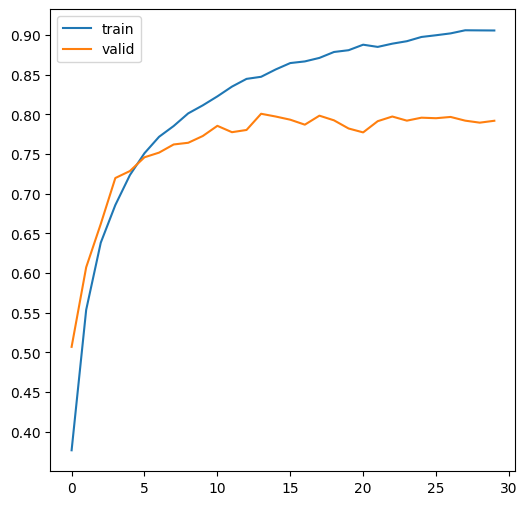

In [16]:
# 결과를 보면 알겠지만 오버피팅의 경향을 보이고 있음

import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(model_fit)

model.evaluate(test_images, test_labels)

### model.predict()를 통해 이미지 분류 예측
* 4차원 이미지 배열을 입력해서 모델학습을 하는 경우, predict시에도 4차원 이미지 배열을 입력해야 한다.
* 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이 나오므로 이에 유의하자.

In [17]:
# 아래 코드는 Conv2D를 사용한 모델에 4차원 이미지 배열을 입력해야 하는데 3차원 이미지 배열을 넣어서 오류 발생
# 개별 이미지를 사용하는 경우 3차원 데이터가 model에 입력되므로 오류 발생

test_images[0].shape  # 3차원 배열

# preds = model.predict(test_images[0])

(32, 32, 3)

In [18]:
# 테스트용 4차원 이미지 배열을 입력해서 predict 수행
# predict의 결과는 softmax 적용 결과다 
# 이는 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이다.

preds = model.predict(np.expand_dims(test_images[0], axis=0))
print('예측 결과 shape', preds.shape)
print('예측 결과', preds)

1/1 [==============================] - 1s 547ms/step
예측 결과 shape (1, 10)
예측 결과 [[3.9526774e-05 3.4326181e-06 2.2805789e-03 9.1233772e-01 7.3626623e-05
  6.5876536e-02 1.8596927e-02 1.3872047e-04 6.4670522e-04 6.1428432e-06]]


In [19]:
print(test_images[:16].shape) # (16, 32, 32, 3)

preds = model.predict(test_images[:32], batch_size=32)
print(preds.shape)
print(preds)

(16, 32, 32, 3)
1/1 [==============================] - 0s 20ms/step
(32, 10)
[[3.95269453e-05 3.43264264e-06 2.28060293e-03 9.12337363e-01
  7.36278525e-05 6.58766851e-02 1.85971949e-02 1.38721211e-04
  6.46717963e-04 6.14292867e-06]
 [1.39780553e-15 2.91083097e-07 4.65465366e-24 2.79766959e-20
  1.98923418e-26 1.17758753e-21 1.02380630e-18 2.40268019e-26
  9.99999762e-01 1.56123009e-12]
 [8.43516972e-08 3.46947104e-06 6.77655917e-11 3.77088014e-08
  6.35437807e-15 6.40970003e-12 7.39312824e-08 1.04079289e-13
  9.99996185e-01 1.75042501e-07]
 [4.81487095e-01 3.85911408e-04 8.33889062e-05 6.43834574e-05
  5.57066983e-07 5.61370541e-08 1.14114023e-07 6.58048407e-08
  5.13716757e-01 4.26168740e-03]
 [5.99174139e-12 1.49502025e-11 8.61377412e-05 2.82565870e-05
  2.28657354e-05 1.64252029e-10 9.99862671e-01 1.44525152e-13
  2.77897083e-09 1.87054794e-09]
 [1.74570028e-04 1.24281883e-04 3.20424396e-03 1.94452450e-01
  1.46531582e-01 4.70017642e-01 9.61641744e-02 8.89314562e-02
  1.68819577e-

In [20]:
predicted_class = np.argmax(preds, axis=1)
print('예측 클래스 값',predicted_class)

예측 클래스 값 [3 8 8 8 6 5 1 4 3 9 4 9 5 7 9 8 5 7 8 6 0 0 4 9 4 2 4 0 9 6 6 5]


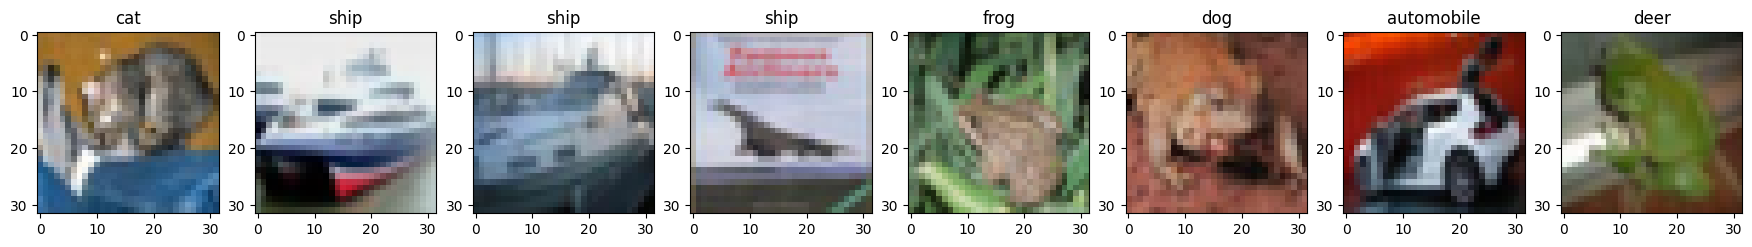

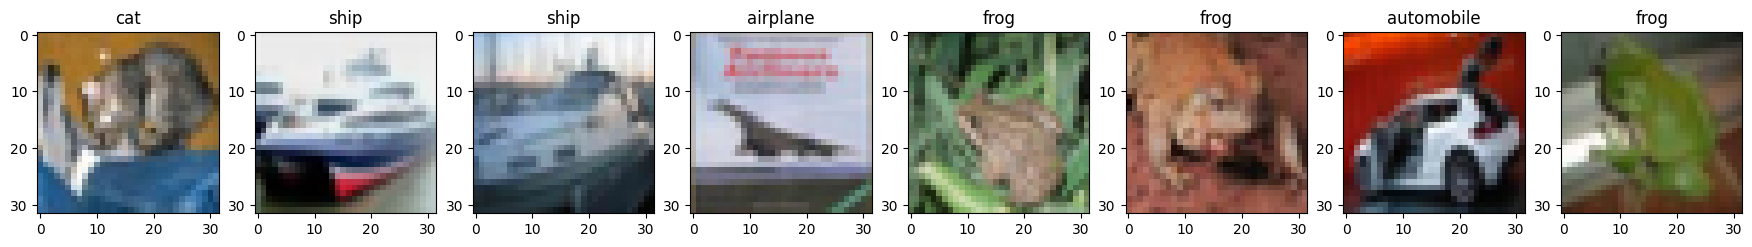

In [21]:
show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)

## weight 초기화
* 좋은 weight 초기화 조건은 아래와 같다.
    1. 값이 동일하지 않다.
    2. 충분히 작아야 한다. / 안 그러면 x1w11 + x2w12..의 연산 과정에서 값이 지나치게 커진다
    3. 적당한 분산(혹은 표준편차)를 가져야 한다.
* 이를 위해 시용되는 초기화 식으론 Xavier Initialization, He Initialization 등이 있다.

### Xavier initialization / 정규분포(glorot_normal), 균일분포(glorot_uniform)
* Xavier initialization은 주로 비선형함수(sigmoid, tanh 등)에서 효과적이다.
* 하지만 ReLU함수에 있어선 사용 시 출력 값이 0으로 수렴하는 현상이 있어 다른 방법이 필요하다.

In [22]:
# glorot_normal

fan_in = 20
fan_out = 15
scale_value = np.sqrt(2/(fan_in + fan_out))
print('scale:', scale_value)
weights = np.random.normal(loc=0.0, scale=scale_value, size=(100,100))
print(weights)
print('weights mean:', weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

scale: 0.23904572186687872
[[-0.04016938  0.14609739  0.05099029 ...  0.02927149 -0.04934083
  -0.37571487]
 [-0.16810952 -0.01805347  0.00381319 ...  0.25981582  0.16518415
  -0.12130743]
 [ 0.41766046  0.44797636 -0.24376083 ... -0.04133887  0.00378638
   0.01702778]
 ...
 [ 0.20743008  0.28746855  0.34805956 ...  0.36690961  0.05697188
  -0.02855581]
 [-0.42297698  0.16344385  0.1138203  ... -0.23276588 -0.29494015
   0.04331166]
 [-0.19143017 -0.0142426  -0.1314629  ... -0.42961535  0.11461675
   0.1811814 ]]
weights mean: -0.0028195466937144236 std: 0.23639084669201574 sum: -28.195466937144236


In [23]:
# glorot_uniform

fan_in = 10
fan_out = 8
limit = np.sqrt(6/(fan_in + fan_out))
print('limit:', limit)
weights = np.random.uniform(-1*limit, limit, size=(100, 100))
print(weights)
print('weights mean:',weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

limit: 0.5773502691896257
[[ 0.1321499  -0.02066947 -0.39340497 ...  0.36967469  0.16052781
  -0.2577483 ]
 [-0.10917129  0.26190757 -0.22948305 ... -0.00187216 -0.06187713
  -0.15348943]
 [-0.28825444  0.3118469   0.37704571 ...  0.16641476  0.50842137
  -0.13253254]
 ...
 [ 0.40849877  0.2055052   0.53695181 ... -0.49216417  0.3658319
   0.16663648]
 [-0.06887144  0.31651111  0.57367185 ...  0.31686295 -0.09335252
   0.56343242]
 [-0.36607781  0.00952181 -0.56506349 ... -0.16159573 -0.54748612
   0.48293096]]
weights mean: 0.0044552399444898055 std: 0.3336120633159114 sum: 44.55239944489806


### He initialization - 정규분포(he_normal), 균일분포(he_uniform)
* He initialization의 경우 ReLu 함수 사용 시 weights를 초기화에 적합하다.

In [24]:
fan_in = 10
fan_out = 8
scale_value = np.sqrt(2/(fan_in))
print('scale:', scale_value)
weights = np.random.normal(loc=0.0, scale=scale_value, size=(100, 100))
print(weights)
print('weights mean:',weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

scale: 0.4472135954999579
[[ 0.17410392  0.2119681   0.19565914 ... -0.26562391 -0.40042719
  -0.32506492]
 [ 0.25110814 -0.09070134  0.06157408 ...  0.17758826  0.25574243
   0.72148548]
 [-0.13106285 -0.65969888 -0.67197833 ... -0.31142842 -0.21571434
  -0.39942876]
 ...
 [ 0.28558657  0.56364634  1.03396779 ...  0.07754488 -0.44901626
  -0.16104732]
 [ 0.47284461 -0.64226323 -0.39120896 ...  0.34147596  0.08985968
  -0.02463193]
 [-0.45124764 -0.20953843  0.07158656 ...  0.02678159 -0.20027343
   0.87069743]]
weights mean: -0.0012866669539074828 std: 0.4492460964279731 sum: -12.86666953907483


In [25]:
fan_in = 10
fan_out = 8
limit = np.sqrt(6/(fan_in))
print('limit:', limit)
weights = np.random.uniform(-1*limit, limit, size=(100,100))
print(weights)
print('weights mean:', weights.mean(),'std:', weights.std(), 'sum:', weights.sum())

limit: 0.7745966692414834
[[-0.34313229 -0.02740215  0.21621291 ...  0.28265856  0.09531116
  -0.63795656]
 [ 0.30725007 -0.17645075 -0.47443848 ... -0.43083171  0.01702947
   0.37440718]
 [-0.40987868  0.14236614  0.57225527 ... -0.43905205  0.28098744
  -0.17392008]
 ...
 [-0.15055972  0.04902661 -0.0736221  ... -0.17891479  0.01062251
   0.75407717]
 [-0.10367635  0.44509508  0.10619504 ... -0.11071361  0.34725472
  -0.76348454]
 [-0.18550241  0.08958817 -0.44502882 ... -0.48128476  0.03932052
   0.60021723]]
weights mean: -0.0010680309651993616 std: 0.4466120852931302 sum: -10.680309651993616


### weight 초기화를 He Normal로 변경 후 테스트
* keras conv2d의 기본 weights 초기화는 glorot_uniform인데, 이를 he_normal로 변경 후 동일 모델로 성능 검증
* label의 경우 one hot encoding 적용

In [26]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사잇값으로 scale 및 float32로 타입 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    labels = labels.squeeze()
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # ohe 적용
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
print(train_images.shape, train_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [27]:
IMAGE_SIZE=32

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개라 마지막 classification의 dense layer units 개수는 10개
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

kernel_initialized_model = Model(inputs=input_tensor, outputs=output)

kernel_initialized_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                           

In [29]:
kernel_initialized_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = kernel_initialized_model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 9s 9ms/step - loss: 1.6367 - accuracy: 0.3991 - val_loss: 1.3301 - val_accuracy: 0.5212
Epoch 2/30
665/665 [==============================] - 6s 9ms/step - loss: 1.1957 - accuracy: 0.5696 - val_loss: 1.0365 - val_accuracy: 0.6248
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9947 - accuracy: 0.6452 - val_loss: 0.9500 - val_accuracy: 0.6636
Epoch 4/30
665/665 [==============================] - 6s 8ms/step - loss: 0.8741 - accuracy: 0.6907 - val_loss: 0.7921 - val_accuracy: 0.7227
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7749 - accuracy: 0.7260 - val_loss: 0.7801 - val_accuracy: 0.7288
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7097 - accuracy: 0.7494 - val_loss: 0.7277 - val_accuracy: 0.7464
Epoch 7/30
665/665 [==============================] - 6s 8ms/step - loss: 0.6475 - accuracy: 0.7742 - val_loss: 0.6886 - val_accuracy: 0.7604
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 0.7296 - accuracy: 0.7904


[0.729576587677002, 0.7904000282287598]

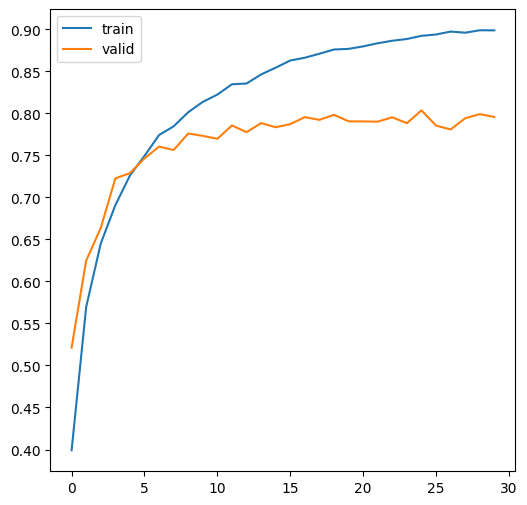

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

# 테스트 데이터로 성능 평가
kernel_initialized_model.evaluate(test_images, test_oh_labels)

### Batch Normalization 적용
* internal covariate shift 해결(신경망 내부 각 층을 통과하면서 입력 데이터 분포가 조금씩 달라지는 현상)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

input_tensor= Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

batch_normalized_model = Model(inputs=input_tensor, outputs=output)

batch_normalized_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                          

In [32]:
batch_normalized_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = batch_normalized_model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 11s 11ms/step - loss: 1.5858 - accuracy: 0.4239 - val_loss: 1.5147 - val_accuracy: 0.4712
Epoch 2/30
665/665 [==============================] - 6s 9ms/step - loss: 1.1118 - accuracy: 0.6030 - val_loss: 1.4788 - val_accuracy: 0.5160
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9144 - accuracy: 0.6797 - val_loss: 0.8912 - val_accuracy: 0.6856
Epoch 4/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7957 - accuracy: 0.7205 - val_loss: 0.7683 - val_accuracy: 0.7317
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7181 - accuracy: 0.7496 - val_loss: 0.7317 - val_accuracy: 0.7464
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6479 - accuracy: 0.7754 - val_loss: 0.7633 - val_accuracy: 0.7336
Epoch 7/30
665/665 [==============================] - 6s 10ms/step - loss: 0.5933 - accuracy: 0.7952 - val_loss: 0.8373 - val_accuracy: 0.7353
Epo

313/313 [==============================] - 2s 4ms/step - loss: 0.8933 - accuracy: 0.7985


[0.8933385014533997, 0.7985000014305115]

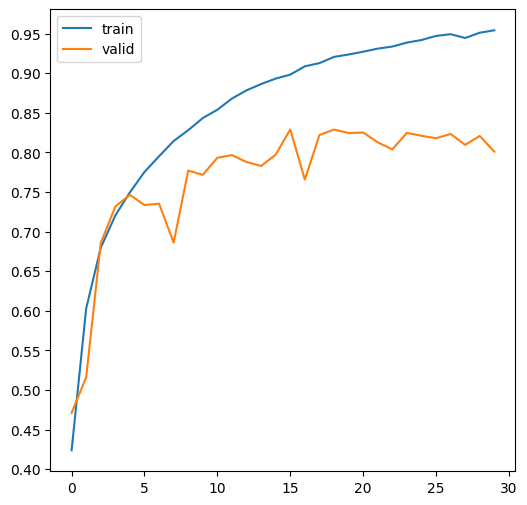

In [33]:
show_history(history)

batch_normalized_model.evaluate(test_images, test_oh_labels)

### He Normal Batch Normalization 동시 적용

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                          

In [35]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 10s 10ms/step - loss: 1.5557 - accuracy: 0.4357 - val_loss: 1.1790 - val_accuracy: 0.5697
Epoch 2/30
665/665 [==============================] - 6s 9ms/step - loss: 1.1334 - accuracy: 0.5943 - val_loss: 1.0572 - val_accuracy: 0.6276
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9394 - accuracy: 0.6726 - val_loss: 1.0771 - val_accuracy: 0.6245
Epoch 4/30
665/665 [==============================] - 7s 10ms/step - loss: 0.8128 - accuracy: 0.7203 - val_loss: 0.7728 - val_accuracy: 0.7299
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7342 - accuracy: 0.7442 - val_loss: 0.8765 - val_accuracy: 0.6871
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6694 - accuracy: 0.7712 - val_loss: 0.7060 - val_accuracy: 0.7519
Epoch 7/30
665/665 [==============================] - 6s 9ms/step - loss: 0.5998 - accuracy: 0.7928 - val_loss: 0.7907 - val_accuracy: 0.7420
Epo

313/313 [==============================] - 1s 4ms/step - loss: 0.7359 - accuracy: 0.8180


[0.7359089851379395, 0.8180000185966492]

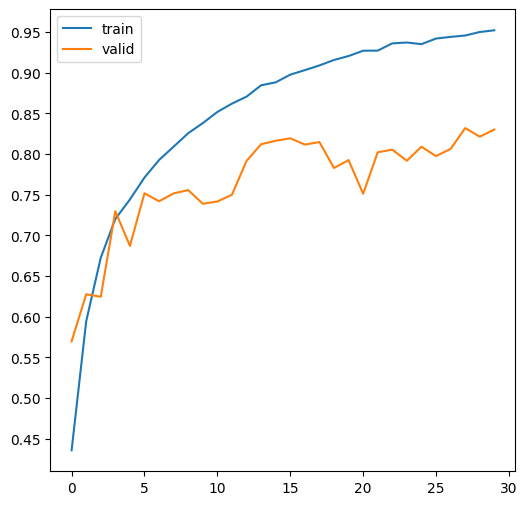

In [36]:
show_history(history)

model.evaluate(test_images, test_oh_labels)